# Setup

In [ ]:
import pandas as pd
import scipy
import copy
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.express as px

from scipy import stats

from sklearn.model_selection import train_test_split

In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()

In [ ]:
def generate_gaussian(rho, sample_size=2000):
  mean = np.zeros(2)
  E = np.zeros(shape=(2, 2)) + rho
  E[0, 0] = 1
  E[1, 1] =1

  D = np.random.multivariate_normal(mean=mean, cov=E, size=(sample_size, )).T

  # Generating Train and test data
  shuf_indexes = np.random.permutation(sample_size)

  train_p = 0.75
  n_train = int(D.shape[1] * train_p)
  n_test = D.shape[1] - n_train

  train_D = D[:, shuf_indexes[:n_train]]
  test_D = D[:, shuf_indexes[n_train:]]

  return train_D, test_D


def GT_gaussian_density(points, rho):
  x = points[0]
  y = points[1]

  c_uv = (1/np.sqrt(1 - rho**2)) * np.exp( ((-1 * rho**2 * x**2 * y**2) - (2*rho*x*y)) / (2*(1 - rho**2)) )
  f_x = stats.norm.pdf(x)
  f_y = stats.norm.pdf(y)

  return c_uv * f_x * f_y

In [ ]:
# Marshal and Olkin
def clayton_sample(theta):
  alpha = 1 / theta
  beta = 1
  V = np.random.gamma(shape=alpha, scale=beta)
  R = np.random.exponential(scale=1, size=2)
  t = R / V
  U = (1 + t) ** (-1/theta)
  return U

# Generate Clayton Copula with N(0,1) margins
def generate_clayton_sample(theta, sample_size=2000):
  X = []
  Y = []
  for _ in range(sample_size):
    U = clayton_sample(theta)
    X.append(stats.norm.ppf(U[0]))
    Y.append(stats.norm.ppf(U[1]))

  D = np.concatenate((X, Y)).reshape((2, -1))

  # Generating Train and test data
  shuf_indexes = np.random.permutation(sample_size)

  train_p = 0.75
  n_train = int(D.shape[1] * train_p)
  n_test = D.shape[1] - n_train

  train_D = D[:, shuf_indexes[:n_train]]
  test_D = D[:, shuf_indexes[n_train:]]

  return train_D, test_D

In [ ]:
# Marshal and Olkin
def frank_sample(theta):
  p = 1 - np.exp(-theta)
  V = stats.logser.rvs(p)
  R = np.random.exponential(scale=1, size=2)
  t = R / V
  U = -1/theta * np.log( 1 - ( (1 - np.exp(-theta)) * (np.exp(-t)) ) )
  return U

# Generate Frank Copula with N(0,1) margins
def generate_frank_sample(theta, sample_size=2000):
  X = []
  Y = []
  for _ in range(sample_size):
    U = frank_sample(theta)
    X.append(stats.norm.ppf(U[0]))
    Y.append(stats.norm.ppf(U[1]))

  D = np.concatenate((X, Y)).reshape((2, -1))

  # Generating Train and test data
  shuf_indexes = np.random.permutation(sample_size)

  train_p = 0.75
  n_train = int(D.shape[1] * train_p)
  n_test = D.shape[1] - n_train

  train_D = D[:, shuf_indexes[:n_train]]
  test_D = D[:, shuf_indexes[n_train:]]

  return train_D, test_D

In [ ]:
def visualize_data(D):
  _, ax = plt.subplots(figsize=(5.5, 5))

  ax.scatter(
      D[0],
      D[1],
      s=80,
      edgecolor='k',
      alpha=0.5
  )

  plt.show()

# IGC

## imports

In [ ]:
!git clone https://github.com/TimCJanke/igc

Cloning into 'igc'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 124 (delta 50), reused 110 (delta 41), pack-reused 0
Receiving objects: 100% (124/124), 21.05 MiB | 25.04 MiB/s, done.
Resolving deltas: 100% (50/50), done.


In [ ]:
%cd igc

/content/igc


In [ ]:
!pip install pybind11==2.6.2 pyvinecopulib==0.5.5 setuptools-scm==6.0.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.4/191.4 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyvinecopulib: filename=pyvinecopulib-0.5.5-cp310-cp310-linux_x86_64.whl size=14590995 sha256=87538ab3c266323dceb2ae87dccb15bb66fa371a2f56ffde53c32c33cb5d51c8
  Stored in directory: /root/.cache/pip/wheels/bf/91/96/45e1fb1955095b8a057d148acc15a38654e81c76793705e477
Successfully built pyvinecopulib


In [ ]:
from experiments_utils import run_experiment
from experiments_utils import random_bicop, get_pvcopfamily, beta_copula_cdf, emp_cdf, gaussian_mixture_copula
import pyvinecopulib as pv
from models.igc import ImplicitGenerativeCopula
from scipy.stats import bootstrap

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

def eval_prob(data_models, data_test, bw, n_eval=10000):
    # evaluate likelihood of test data under KDE based likelihood from trained models
    nll={}
    if bw is None:
        grid_cv = GridSearchCV(KernelDensity(), param_grid={"bandwidth": np.logspace(-1.0,1.0,10)}) # use CV to find best bandwidth on the test data
        grid_cv.fit(data_test)
        bw_opt = grid_cv.best_params_["bandwidth"]
        print(bw_opt)

    elif isinstance(bw, (list, tuple, np.ndarray)):
        grid_cv = GridSearchCV(KernelDensity(), param_grid={"bandwidth": bw}) # use CV to find best bandwidth on the test data
        grid_cv.fit(data_test)
        bw_opt = grid_cv.best_params_["bandwidth"]
        print(bw_opt)

    elif isinstance(bw, float):
        bw_opt = bw

    for key_i, y_i in data_models.items():
        kde_model = KernelDensity(bandwidth=bw_opt).fit(y_i)
        yhat = kde_model.score_samples(data_test[0:n_eval]) # compute likelihood of test data under KDE
    return yhat

## example (gaussians)

In [ ]:
r=10.0
N=10000
data = []
data.append(stats.multivariate_normal([r, 0], [[1.0, 0.0], [0.0, 1.0]]).rvs(N))
data.append(stats.multivariate_normal([0, r], [[1.0, 0.0], [0.0, 1.0]]).rvs(N))
data.append(stats.multivariate_normal([-r, 0], [[1.0, 0.0], [0.0, 1.0]]).rvs(N))
data.append(stats.multivariate_normal([0, -r], [[1.0, 0.0], [0.0, 1.0]]).rvs(N))

data.append(stats.multivariate_normal([r/np.sqrt(2), r/np.sqrt(2)], [[1.0, 0.0], [0.0, 1.0]]).rvs(N))
data.append(stats.multivariate_normal([-r/np.sqrt(2), -r/np.sqrt(2)], [[1.0, 0.0], [0.0, 1.0]]).rvs(N))
data.append(stats.multivariate_normal([r/np.sqrt(2), -r/np.sqrt(2)], [[1.0, 0.0], [0.0, 1.0]]).rvs(N))
data.append(stats.multivariate_normal([-r/np.sqrt(2), r/np.sqrt(2)], [[1.0, 0.0], [0.0, 1.0]]).rvs(N))
data = np.vstack(data)

In [ ]:
data.shape

(80000, 2)

In [ ]:
np.random.shuffle(data)
data_train = data[0:5000]
data_test = data[5000:10000]

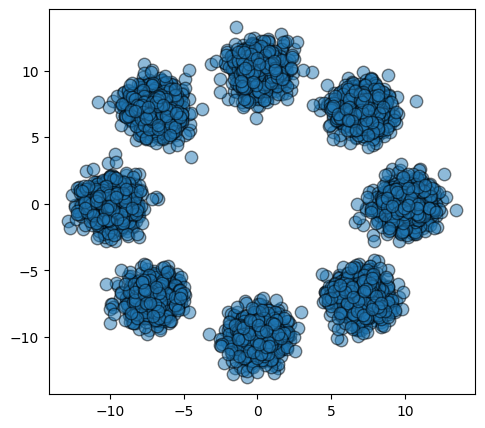

In [ ]:
visualize_data(data_train.T)

In [ ]:
all_scores, data_models_v, data_models_y, models_joint, models_margins = run_experiment(data_train,
                                                                        data_test,
                                                                        evaluate_likelihood=True,
                                                                        GaussCop=False,
                                                                        VineCop=False,
                                                                        GMMNCop=False,
                                                                        GMMNFull=False,
                                                                        GAN = False,
                                                                        IGC=True,
                                                                        options_nn={"n_neurons": 100, "n_layers": 2, "n_samples_train": 200},
                                                                        options_nn_training={"epochs": 500, "batch_size": 100},
                                                                        options_gan={"n_neurons": 100, "n_layers": 2},
                                                                        options_gan_training={"epochs": 500, "batch_size": 100},
                                                                        bw_kde = 0.15)

Training models ...


100%|██████████| 500/500 [03:42<00:00,  2.24it/s]


157/157 [==============================] - 0s 1ms/step
Done.

Sampling data for evalutation...
16/16 [==============================] - 0s 1ms/step
Done.

Computing evaluation metrics...
LogLikelihood data space...
All done.



In [ ]:
all_scores

,NLL_dataspace
igc,5.168998


In [ ]:
sample = models_joint['igc'].simulate(n_samples=1000)

1/1 [==============================] - 0s 23ms/step


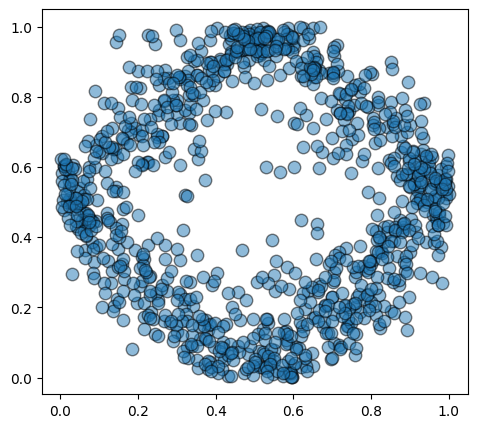

In [ ]:
visualize_data(sample.T)

## Gauss $\rho = 0.1$

In [ ]:
np.random.seed(30091985)

In [ ]:
rho = 0.1
train_D, test_D = generate_gaussian(rho)
# train_D = scaler.fit_transform(train_D.T).T
# test_D = scaler.fit_transform(test_D.T).T

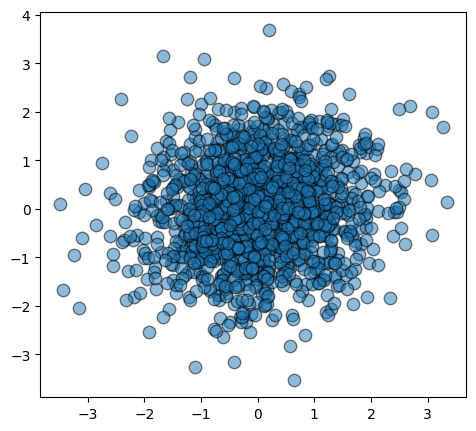

In [ ]:
visualize_data(train_D)

In [ ]:
all_scores, data_models_v, data_models_y, models_joint, models_margins = run_experiment(train_D.T,
                                                                        test_D.T,
                                                                        evaluate_likelihood=True,
                                                                        GaussCop=False,
                                                                        VineCop=False,
                                                                        GMMNCop=False,
                                                                        GMMNFull=False,
                                                                        GAN = False,
                                                                        IGC=True,
                                                                        options_nn={"n_neurons": 100, "n_layers": 2, "n_samples_train": 200},
                                                                        options_nn_training={"epochs": 1000, "batch_size": 100},
                                                                        options_gan={"n_neurons": 100, "n_layers": 2},
                                                                        options_gan_training={"epochs": 500, "batch_size": 100},
                                                                        bw_kde = 0.15)

Training models ...


100%|██████████| 1000/1000 [02:12<00:00,  7.54it/s]


157/157 [==============================] - 0s 1ms/step
Done.

Sampling data for evalutation...
16/16 [==============================] - 0s 2ms/step
Done.

Computing evaluation metrics...
LogLikelihood data space...
All done.



In [ ]:
all_scores

,NLL_dataspace
igc,2.915284


In [ ]:
yhat = -eval_prob(data_models_y, test_D.T, bw=0.15)
nll = np.mean(yhat)
res = bootstrap((yhat,), np.mean)
rmean = res.bootstrap_distribution.mean()
low = res.confidence_interval.low
high = res.confidence_interval.high
dev1 = high - rmean
dev2 = rmean - low
dev = dev1 if dev1 > dev2 else dev2
rmean, res.standard_error, res.confidence_interval
print(f'NLL: {nll:.4f} RMean: {rmean:.4f} IC: ({low:.4f},{high:.4f}) Notation: {rmean:.2f}$\pm${dev:.2f}')

NLL: 2.9153 RMean: 2.9155 IC: (2.8250,3.0177) Notation: 2.92$\pm$0.10


## Gauss $\rho = 0.5$

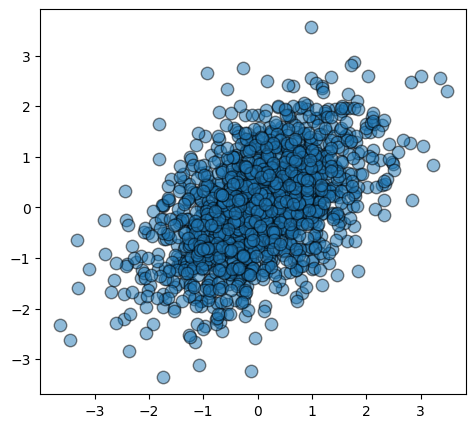

In [ ]:
np.random.seed(30091985)

rho = 0.5
train_D, test_D = generate_gaussian(rho)
# train_D = scaler.fit_transform(train_D.T).T
# test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
all_scores, data_models_v, data_models_y, models_joint, models_margins = run_experiment(train_D.T,
                                                                        test_D.T,
                                                                        evaluate_likelihood=True,
                                                                        GaussCop=False,
                                                                        VineCop=False,
                                                                        GMMNCop=False,
                                                                        GMMNFull=False,
                                                                        GAN = False,
                                                                        IGC=True,
                                                                        options_nn={"n_neurons": 100, "n_layers": 2, "n_samples_train": 200},
                                                                        options_nn_training={"epochs": 500, "batch_size": 100},
                                                                        options_gan={"n_neurons": 100, "n_layers": 2},
                                                                        options_gan_training={"epochs": 500, "batch_size": 100},
                                                                        bw_kde = 0.15)

Training models ...


100%|██████████| 500/500 [01:07<00:00,  7.46it/s]


157/157 [==============================] - 0s 1ms/step
Done.

Sampling data for evalutation...
16/16 [==============================] - 0s 2ms/step
Done.

Computing evaluation metrics...
LogLikelihood data space...
All done.



In [ ]:
all_scores

,NLL_dataspace
igc,2.764269


In [ ]:
yhat = -eval_prob(data_models_y, test_D.T, bw=0.15)
nll = np.mean(yhat)
res = bootstrap((yhat,), np.mean)
rmean = res.bootstrap_distribution.mean()
low = res.confidence_interval.low
high = res.confidence_interval.high
dev1 = high - rmean
dev2 = rmean - low
dev = dev1 if dev1 > dev2 else dev2
rmean, res.standard_error, res.confidence_interval
print(f'NLL: {nll:.4f} RMean: {rmean:.4f} IC: ({low:.4f},{high:.4f}) Notation: {rmean:.2f}$\pm${dev:.2f}')

NLL: 2.7643 RMean: 2.7645 IC: (2.6799,2.8611) Notation: 2.76$\pm$0.10


## Gauss $\rho = 0.9$

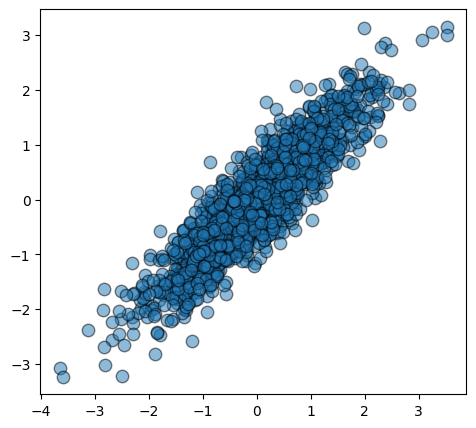

In [ ]:
np.random.seed(30091985)

rho = 0.9
train_D, test_D = generate_gaussian(rho)
# train_D = scaler.fit_transform(train_D.T).T
# test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
all_scores, data_models_v, data_models_y, models_joint, models_margins = run_experiment(train_D.T,
                                                                        test_D.T,
                                                                        evaluate_likelihood=True,
                                                                        GaussCop=False,
                                                                        VineCop=False,
                                                                        GMMNCop=False,
                                                                        GMMNFull=False,
                                                                        GAN = False,
                                                                        IGC=True,
                                                                        options_nn={"n_neurons": 100, "n_layers": 2, "n_samples_train": 200},
                                                                        options_nn_training={"epochs": 500, "batch_size": 100},
                                                                        options_gan={"n_neurons": 100, "n_layers": 2},
                                                                        options_gan_training={"epochs": 500, "batch_size": 100},
                                                                        bw_kde = 0.15)

Training models ...


100%|██████████| 500/500 [01:07<00:00,  7.44it/s]


157/157 [==============================] - 0s 1ms/step
Done.

Sampling data for evalutation...
16/16 [==============================] - 0s 1ms/step
Done.

Computing evaluation metrics...
LogLikelihood data space...
All done.



In [ ]:
all_scores

,NLL_dataspace
igc,2.093053


In [ ]:
yhat = -eval_prob(data_models_y, test_D.T, bw=0.15)
nll = np.mean(yhat)
res = bootstrap((yhat,), np.mean)
rmean = res.bootstrap_distribution.mean()
low = res.confidence_interval.low
high = res.confidence_interval.high
dev1 = high - rmean
dev2 = rmean - low
dev = dev1 if dev1 > dev2 else dev2
rmean, res.standard_error, res.confidence_interval
print(f'NLL: {nll:.4f} RMean: {rmean:.4f} IC: ({low:.4f},{high:.4f}) Notation: {rmean:.2f}$\pm${dev:.2f}')

NLL: 2.0931 RMean: 2.0933 IC: (2.0111,2.1900) Notation: 2.09$\pm$0.10


## Clayton $\theta = 1$

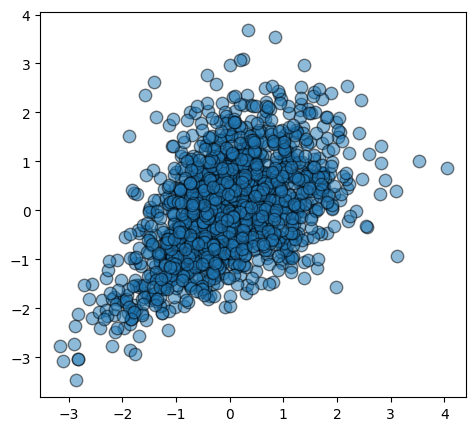

In [ ]:
np.random.seed(30091985)

theta = 1
train_D, test_D = generate_clayton_sample(theta)
# train_D = scaler.fit_transform(train_D.T).T
# test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
all_scores, data_models_v, data_models_y, models_joint, models_margins = run_experiment(train_D.T,
                                                                        test_D.T,
                                                                        evaluate_likelihood=True,
                                                                        GaussCop=False,
                                                                        VineCop=False,
                                                                        GMMNCop=False,
                                                                        GMMNFull=False,
                                                                        GAN = False,
                                                                        IGC=True,
                                                                        options_nn={"n_neurons": 100, "n_layers": 2, "n_samples_train": 200},
                                                                        options_nn_training={"epochs": 500, "batch_size": 100},
                                                                        options_gan={"n_neurons": 100, "n_layers": 2},
                                                                        options_gan_training={"epochs": 500, "batch_size": 100},
                                                                        bw_kde = 0.15)

Training models ...


100%|██████████| 500/500 [01:06<00:00,  7.50it/s]


157/157 [==============================] - 0s 1ms/step
Done.

Sampling data for evalutation...
16/16 [==============================] - 0s 1ms/step
Done.

Computing evaluation metrics...
LogLikelihood data space...
All done.



In [ ]:
all_scores

,NLL_dataspace
igc,2.643614


In [ ]:
yhat = -eval_prob(data_models_y, test_D.T, bw=0.15)
nll = np.mean(yhat)
res = bootstrap((yhat,), np.mean)
rmean = res.bootstrap_distribution.mean()
low = res.confidence_interval.low
high = res.confidence_interval.high
dev1 = high - rmean
dev2 = rmean - low
dev = dev1 if dev1 > dev2 else dev2
rmean, res.standard_error, res.confidence_interval
print(f'NLL: {nll:.4f} RMean: {rmean:.4f} IC: ({low:.4f},{high:.4f}) Notation: {rmean:.2f}$\pm${dev:.2f}')

NLL: 2.6436 RMean: 2.6437 IC: (2.5672,2.7277) Notation: 2.64$\pm$0.08


## Clayton $\theta = 5$

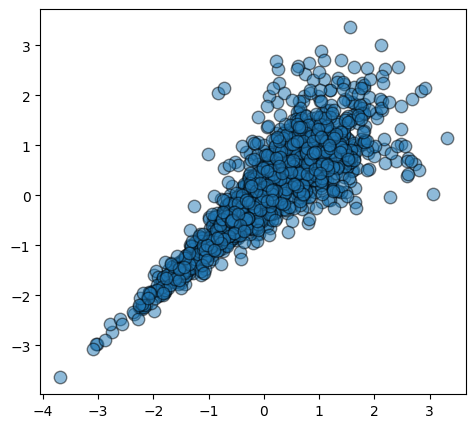

In [ ]:
np.random.seed(30091985)

theta = 5
train_D, test_D = generate_clayton_sample(theta)
# train_D = scaler.fit_transform(train_D.T).T
# test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
all_scores, data_models_v, data_models_y, models_joint, models_margins = run_experiment(train_D.T,
                                                                        test_D.T,
                                                                        evaluate_likelihood=True,
                                                                        GaussCop=False,
                                                                        VineCop=False,
                                                                        GMMNCop=False,
                                                                        GMMNFull=False,
                                                                        GAN = False,
                                                                        IGC=True,
                                                                        options_nn={"n_neurons": 100, "n_layers": 2, "n_samples_train": 200},
                                                                        options_nn_training={"epochs": 500, "batch_size": 100},
                                                                        options_gan={"n_neurons": 100, "n_layers": 2},
                                                                        options_gan_training={"epochs": 500, "batch_size": 100},
                                                                        bw_kde = 0.15)

Training models ...


100%|██████████| 500/500 [01:06<00:00,  7.51it/s]


157/157 [==============================] - 0s 1ms/step
Done.

Sampling data for evalutation...
16/16 [==============================] - 0s 1ms/step
Done.

Computing evaluation metrics...
LogLikelihood data space...
All done.



In [ ]:
all_scores

,NLL_dataspace
igc,1.926203


In [ ]:
yhat = -eval_prob(data_models_y, test_D.T, bw=0.15)
nll = np.mean(yhat)
res = bootstrap((yhat,), np.mean)
rmean = res.bootstrap_distribution.mean()
low = res.confidence_interval.low
high = res.confidence_interval.high
dev1 = high - rmean
dev2 = rmean - low
dev = dev1 if dev1 > dev2 else dev2
rmean, res.standard_error, res.confidence_interval
print(f'NLL: {nll:.4f} RMean: {rmean:.4f} IC: ({low:.4f},{high:.4f}) Notation: {rmean:.2f}$\pm${dev:.2f}')

NLL: 1.9262 RMean: 1.9263 IC: (1.8514,2.0144) Notation: 1.93$\pm$0.09


## Clayton $\theta = 10$

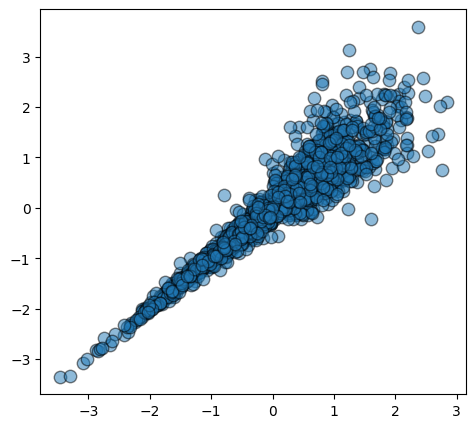

In [ ]:
np.random.seed(30091985)

theta = 10
train_D, test_D = generate_clayton_sample(theta)
# train_D = scaler.fit_transform(train_D.T).T
# test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
all_scores, data_models_v, data_models_y, models_joint, models_margins = run_experiment(train_D.T,
                                                                        test_D.T,
                                                                        evaluate_likelihood=True,
                                                                        GaussCop=False,
                                                                        VineCop=False,
                                                                        GMMNCop=False,
                                                                        GMMNFull=False,
                                                                        GAN = False,
                                                                        IGC=True,
                                                                        options_nn={"n_neurons": 100, "n_layers": 2, "n_samples_train": 200},
                                                                        options_nn_training={"epochs": 500, "batch_size": 100},
                                                                        options_gan={"n_neurons": 100, "n_layers": 2},
                                                                        options_gan_training={"epochs": 500, "batch_size": 100},
                                                                        bw_kde = 0.15)

Training models ...


100%|██████████| 500/500 [01:06<00:00,  7.50it/s]


157/157 [==============================] - 0s 1ms/step
Done.

Sampling data for evalutation...
16/16 [==============================] - 0s 1ms/step
Done.

Computing evaluation metrics...
LogLikelihood data space...
All done.



In [ ]:
all_scores

,NLL_dataspace
igc,1.55743


In [ ]:
yhat = -eval_prob(data_models_y, test_D.T, bw=0.15)
nll = np.mean(yhat)
res = bootstrap((yhat,), np.mean)
rmean = res.bootstrap_distribution.mean()
low = res.confidence_interval.low
high = res.confidence_interval.high
dev1 = high - rmean
dev2 = rmean - low
dev = dev1 if dev1 > dev2 else dev2
rmean, res.standard_error, res.confidence_interval
print(f'NLL: {nll:.4f} RMean: {rmean:.4f} IC: ({low:.4f},{high:.4f}) Notation: {rmean:.2f}$\pm${dev:.2f}')

NLL: 1.5574 RMean: 1.5581 IC: (1.4695,1.6644) Notation: 1.56$\pm$0.11


## Frank $\theta = 1$

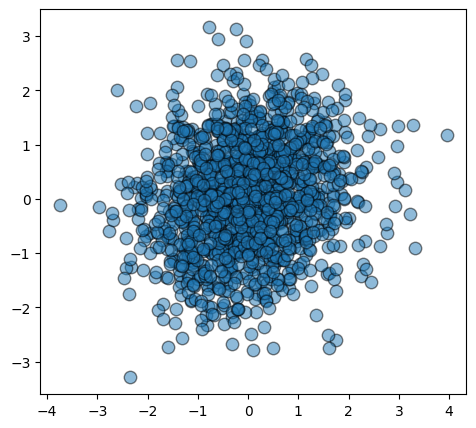

In [ ]:
np.random.seed(30091985)

theta = 1
train_D, test_D = generate_frank_sample(theta)
# train_D = scaler.fit_transform(train_D.T).T
# test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
all_scores, data_models_v, data_models_y, models_joint, models_margins = run_experiment(train_D.T,
                                                                        test_D.T,
                                                                        evaluate_likelihood=True,
                                                                        GaussCop=False,
                                                                        VineCop=False,
                                                                        GMMNCop=False,
                                                                        GMMNFull=False,
                                                                        GAN = False,
                                                                        IGC=True,
                                                                        options_nn={"n_neurons": 100, "n_layers": 2, "n_samples_train": 200},
                                                                        options_nn_training={"epochs": 500, "batch_size": 100},
                                                                        options_gan={"n_neurons": 100, "n_layers": 2},
                                                                        options_gan_training={"epochs": 500, "batch_size": 100},
                                                                        bw_kde = 0.15)

Training models ...


100%|██████████| 500/500 [01:06<00:00,  7.48it/s]


157/157 [==============================] - 0s 1ms/step
Done.

Sampling data for evalutation...
16/16 [==============================] - 0s 1ms/step
Done.

Computing evaluation metrics...
LogLikelihood data space...
All done.



In [ ]:
all_scores

,NLL_dataspace
igc,2.872955


In [ ]:
yhat = -eval_prob(data_models_y, test_D.T, bw=0.15)
nll = np.mean(yhat)
res = bootstrap((yhat,), np.mean)
rmean = res.bootstrap_distribution.mean()
low = res.confidence_interval.low
high = res.confidence_interval.high
dev1 = high - rmean
dev2 = rmean - low
dev = dev1 if dev1 > dev2 else dev2
rmean, res.standard_error, res.confidence_interval
print(f'NLL: {nll:.4f} RMean: {rmean:.4f} IC: ({low:.4f},{high:.4f}) Notation: {rmean:.2f}$\pm${dev:.2f}')

NLL: 2.8730 RMean: 2.8733 IC: (2.7904,2.9657) Notation: 2.87$\pm$0.09


## Frank $\theta = 5$

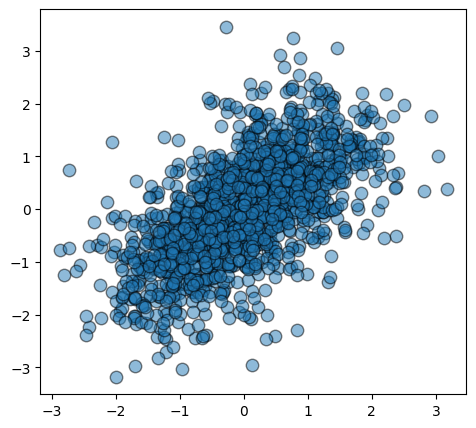

In [ ]:
np.random.seed(30091985)

theta = 5
train_D, test_D = generate_frank_sample(theta)
# train_D = scaler.fit_transform(train_D.T).T
# test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
all_scores, data_models_v, data_models_y, models_joint, models_margins = run_experiment(train_D.T,
                                                                        test_D.T,
                                                                        evaluate_likelihood=True,
                                                                        GaussCop=False,
                                                                        VineCop=False,
                                                                        GMMNCop=False,
                                                                        GMMNFull=False,
                                                                        GAN = False,
                                                                        IGC=True,
                                                                        options_nn={"n_neurons": 100, "n_layers": 2, "n_samples_train": 200},
                                                                        options_nn_training={"epochs": 500, "batch_size": 100},
                                                                        options_gan={"n_neurons": 100, "n_layers": 2},
                                                                        options_gan_training={"epochs": 500, "batch_size": 100},
                                                                        bw_kde = 0.15)

Training models ...


100%|██████████| 500/500 [01:07<00:00,  7.43it/s]


157/157 [==============================] - 0s 1ms/step
Done.

Sampling data for evalutation...
16/16 [==============================] - 0s 1ms/step
Done.

Computing evaluation metrics...
LogLikelihood data space...
All done.



In [ ]:
all_scores

,NLL_dataspace
igc,2.742823


In [ ]:
yhat = -eval_prob(data_models_y, test_D.T, bw=0.15)
nll = np.mean(yhat)
res = bootstrap((yhat,), np.mean)
rmean = res.bootstrap_distribution.mean()
low = res.confidence_interval.low
high = res.confidence_interval.high
dev1 = high - rmean
dev2 = rmean - low
dev = dev1 if dev1 > dev2 else dev2
rmean, res.standard_error, res.confidence_interval
print(f'NLL: {nll:.4f} RMean: {rmean:.4f} IC: ({low:.4f},{high:.4f}) Notation: {rmean:.2f}$\pm${dev:.2f}')

NLL: 2.7428 RMean: 2.7429 IC: (2.6429,2.8628) Notation: 2.74$\pm$0.12


## Frank $\theta = 10$

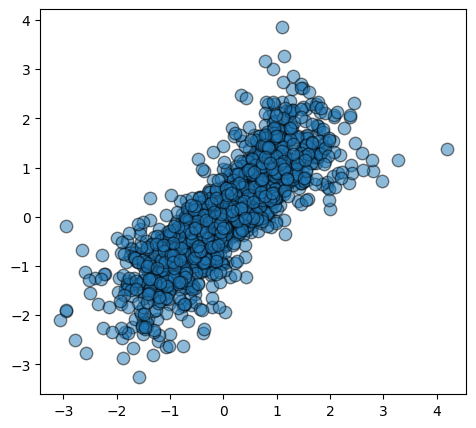

In [ ]:
np.random.seed(30091985)

theta = 10
train_D, test_D = generate_frank_sample(theta)
# train_D = scaler.fit_transform(train_D.T).T
# test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
all_scores, data_models_v, data_models_y, models_joint, models_margins = run_experiment(train_D.T,
                                                                        test_D.T,
                                                                        evaluate_likelihood=True,
                                                                        GaussCop=False,
                                                                        VineCop=False,
                                                                        GMMNCop=False,
                                                                        GMMNFull=False,
                                                                        GAN = False,
                                                                        IGC=True,
                                                                        options_nn={"n_neurons": 100, "n_layers": 2, "n_samples_train": 200},
                                                                        options_nn_training={"epochs": 500, "batch_size": 100},
                                                                        options_gan={"n_neurons": 100, "n_layers": 2},
                                                                        options_gan_training={"epochs": 500, "batch_size": 100},
                                                                        bw_kde = 0.15)

Training models ...


100%|██████████| 500/500 [01:06<00:00,  7.49it/s]


157/157 [==============================] - 0s 1ms/step
Done.

Sampling data for evalutation...
16/16 [==============================] - 0s 1ms/step
Done.

Computing evaluation metrics...
LogLikelihood data space...
All done.



In [ ]:
all_scores

,NLL_dataspace
igc,2.319723


In [ ]:
yhat = -eval_prob(data_models_y, test_D.T, bw=0.15)
nll = np.mean(yhat)
res = bootstrap((yhat,), np.mean)
rmean = res.bootstrap_distribution.mean()
low = res.confidence_interval.low
high = res.confidence_interval.high
dev1 = high - rmean
dev2 = rmean - low
dev = dev1 if dev1 > dev2 else dev2
rmean, res.standard_error, res.confidence_interval
print(f'NLL: {nll:.4f} RMean: {rmean:.4f} IC: ({low:.4f},{high:.4f}) Notation: {rmean:.2f}$\pm${dev:.2f}')

NLL: 2.3197 RMean: 2.3200 IC: (2.2102,2.4534) Notation: 2.32$\pm$0.13
